In [ ]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow h5py

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# pd.set_option('display.max_rows', None)
fp = "./features_combined.csv"
batch_pd = pd.read_csv(fp, index_col=False)
dataset = batch_pd.copy()
dataset.sort_values(by=['policy'], ascending=True, inplace=True)
dataset

,policy,barcode,cycle_life,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,QDiffLinVar
41,1C_4PER_6C,???,300.0,1.070054,0.003530,1.038452,-0.868309,-1.146677,-2.745713,-0.310813,-0.054311,-3.862233,-0.000352,1.078732,-0.000647,1.104041,-2.743232
42,2C_10PER_6C,???,148.0,1.072070,0.001546,0.968339,-0.860038,-1.109668,-2.726901,-0.031052,-0.292914,-4.713663,-0.001088,1.084260,-0.001378,1.106627,-2.725386
43,2C_2PER_5C,???,438.0,1.073539,0.006428,1.075998,-1.263094,-1.610985,-3.493259,-0.769044,0.108508,-4.377028,-0.000012,1.078649,-0.000057,1.081674,-3.492122
44,2C_7PER_5_5C,???,335.0,1.066851,0.002059,1.046734,-0.996793,-1.246302,-2.929546,-0.374625,0.014785,-4.533756,-0.000225,1.072454,-0.000349,1.081733,-2.929246
0,3_6C-80PER_3_6C,???,1189.0,1.070689,0.468365,1.075913,-2.072648,-2.541602,-5.014861,-0.274041,0.129790,-4.261444,-0.000210,1.091262,0.000039,1.072078,-5.013791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,8C-15PER_3_6C,???,965.0,1.083303,0.004503,1.085735,-1.536171,-1.898638,-4.055213,-0.604665,0.093945,-4.637046,-0.000008,1.087331,-0.000042,1.089934,-4.055273
38,8C-25PER_3_6C,???,650.0,1.068239,0.003432,1.068836,-1.350608,-1.717477,-3.667779,-0.624787,0.114815,-4.330611,-0.000024,1.071736,-0.000040,1.072816,-3.670995
37,8C-25PER_3_6C,???,701.0,1.079873,0.004960,1.083282,-1.349599,-1.686149,-3.665856,-0.967808,0.119336,-3.399592,0.000003,1.083766,-0.000036,1.086800,-3.670152
40,8C-35PER_3_6C,???,598.0,1.083956,0.004482,1.085828,-1.226188,-1.539612,-3.425292,-0.938556,0.107343,-3.975854,-0.000012,1.087803,-0.000037,1.089569,-3.425336


In [4]:
dataset.isna().sum()
dataset = dataset.dropna().drop(columns=['policy', 'barcode'])

## Data split

In [5]:
normal_charge_dataset = dataset.iloc[0:29, :]
fast_charge_dataset = dataset.iloc[29:, :]
print(normal_charge_dataset.shape, fast_charge_dataset.shape)

(29, 15) (51, 15)


## Fast-Charge Test-Train split

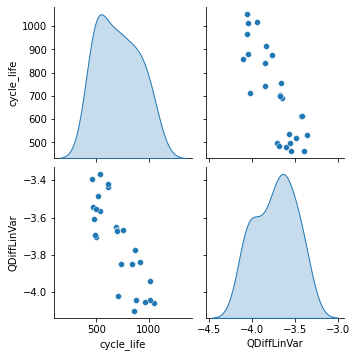

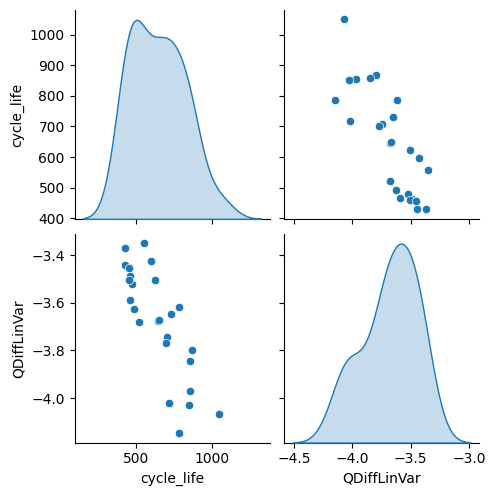

In [6]:
fast_charge_train_ds = fast_charge_dataset.iloc[0::2, :]
fast_charge_test_ds = fast_charge_dataset.iloc[1::2, :]
sns.pairplot(fast_charge_train_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
sns.pairplot(fast_charge_test_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
# fast_charge_test_ds

In [7]:
fast_charge_train_ds.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
cycle_life,26.0,709.000000,193.796801,462.000000,522.500000,702.000000,871.500000,1053.000000
QD2,26.0,1.075827,0.009765,1.042137,1.071382,1.076585,1.079837,1.094639
QD(Max-2),26.0,0.075046,0.355479,0.003094,0.004385,0.005073,0.006637,1.817914
QD100,26.0,1.078456,0.009938,1.047023,1.074762,1.079679,1.084353,1.095349
QDiffMin,26.0,-1.382534,0.113311,-1.558986,-1.484180,-1.358293,-1.301282,-1.196677
QDiffMean,26.0,-1.727856,0.132935,-1.938902,-1.845678,-1.687956,-1.632366,-1.484179
QDiffVar,26.0,-3.730928,0.231815,-4.099414,-3.917423,-3.678960,-3.560911,-3.367237
QDiffSkew,26.0,-0.938650,0.414006,-1.993884,-1.193384,-0.859011,-0.607692,-0.368971
QDiffKurtosis,26.0,0.103841,0.022956,0.030487,0.091231,0.110055,0.119106,0.134112
QDiffStart,26.0,-4.188883,0.509219,-5.440747,-4.527603,-4.178977,-3.776694,-3.399592


In [8]:
fastcharge_train_features = fast_charge_train_ds.copy()
fastcharge_test_features = fast_charge_test_ds.copy()

train_labels = fastcharge_train_features.pop('cycle_life')
test_labels = fastcharge_test_features.pop('cycle_life')


## Normalization Layer

In [9]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(fastcharge_train_features))
print(normalizer.mean.numpy())

[[ 1.0758275e+00  7.5045608e-02  1.0784563e+00 -1.3825345e+00
  -1.7278563e+00 -3.7309279e+00 -9.3865043e-01  1.0384106e-01
  -4.1888828e+00 -1.5772994e-05  1.0812061e+00 -5.3267693e-05
   1.0837196e+00 -3.7306404e+00]]


2022-07-14 15:41:49.889569: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Linear Regress
## Layering

In [10]:
QDiffLinVar = np.array(fastcharge_train_features['QDiffLinVar'])
QDiffLinVar_normalizer = layers.Normalization(input_shape=[1,], axis=None)
QDiffLinVar_normalizer.adapt(QDiffLinVar)

## Model Building

In [11]:
#removed DNN layers
variance_model_fast_charge = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(1, activation='relu'),
    layers.Dense(1, activation='linear')
])

variance_model_fast_charge.summary()
print("Number of weights after calling the model:", len(variance_model_fast_charge.weights))
print("weights:", len(variance_model_fast_charge.weights))
print("trainable_weights:", len(variance_model_fast_charge.trainable_weights))
print("non_trainable_weights:", len(variance_model_fast_charge.non_trainable_weights))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________
Number of weights after calling the model: 7
weights: 7
trainable_weights: 4
non_trainable_weights: 3


In [12]:
variance_model_fast_charge.predict(QDiffLinVar[:10])

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.30256325],
       [0.28863132],
       [0.34131274],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [13]:
variance_model_fast_charge.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
    )

In [14]:
%%time
history = variance_model_fast_charge.fit(
    fastcharge_train_features['QDiffLinVar'],
    train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/1000
1/1 [==============================] - 1s 566ms/step - loss: 539076.0000 - mae: 704.5537 - val_loss: 537140.8750 - val_mae: 723.4306
Epoch 2/1000
1/1 [==============================] - 0s 27ms/step - loss: 539072.3750 - mae: 704.5515 - val_loss: 537137.8750 - val_mae: 723.4287
Epoch 3/1000
1/1 [==============================] - 0s 27ms/step - loss: 539068.8125 - mae: 704.5493 - val_loss: 537134.9375 - val_mae: 723.4269
Epoch 4/1000
1/1 [==============================] - 0s 31ms/step - loss: 539065.2500 - mae: 704.5472 - val_loss: 537131.9375 - val_mae: 723.4250
Epoch 5/1000
1/1 [==============================] - 0s 52ms/step - loss: 539061.6875 - mae: 704.5449 - val_loss: 537129.0000 - val_mae: 723.4232
Epoch 6/1000
1/1 [==============================] - 0s 31ms/step - loss: 539058.1250 - mae: 704.5428 - val_loss: 537126.0625 - val_mae: 723.4212
Epoch 7/1000
1/1 [==============================] - 0s 31ms/step - loss: 539054.5000 - mae: 704.5405 - val_loss: 537123.0625 - va

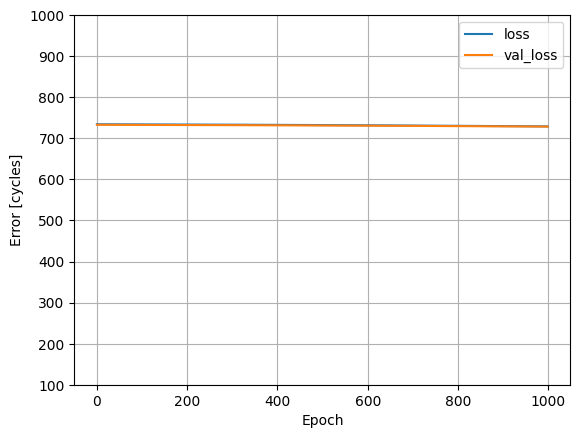

In [15]:
def plot_loss(history):
  plt.plot(np.sqrt(history.history['loss']), label='loss')
  plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
  # plt.ylim([200, 130])
  plt.ylim([100, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [16]:
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist


,loss,mae,val_loss,val_mae,epoch
0,734.217951,26.543431,732.898953,26.896665,0
1,734.215483,26.543389,732.896906,26.896630,1
2,734.213057,26.543348,732.894902,26.896597,2
3,734.210631,26.543308,732.892855,26.896561,3
4,734.208204,26.543265,732.890851,26.896527,4
...,...,...,...,...,...
995,729.044709,26.455623,728.575365,26.823197,995
996,729.036822,26.455490,728.568931,26.823088,996
997,729.028977,26.455357,728.562497,26.822978,997
998,729.021090,26.455225,728.555978,26.822870,998


In [17]:
test_results = {}

test_results['fast_charge_variance_model'] = variance_model_fast_charge.evaluate(
    fastcharge_test_features['QDiffLinVar'],
    test_labels, verbose=1) #sqrt for mse

1/1 [==============================] - 0s 19ms/step - loss: 442021.8750 - mae: 643.6731


## Predict

26 25


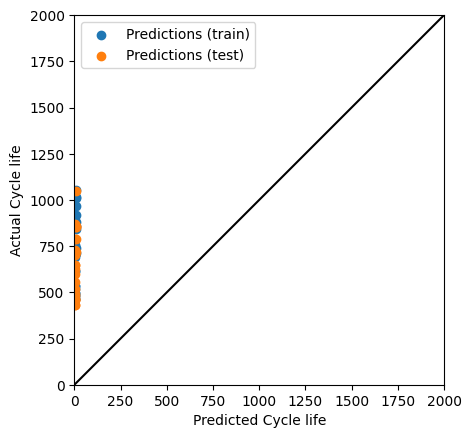

In [18]:
def plot_prediction(y_train, y_test):
  plt.axes(aspect='equal')
  plt.scatter(y_train, train_labels, label='Predictions (train)')
  plt.scatter(y_test, test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

train_prediction = variance_model_fast_charge.predict(fast_charge_train_ds['QDiffLinVar'])
test_prediction = variance_model_fast_charge.predict(fast_charge_test_ds['QDiffLinVar'])
plot_prediction(train_prediction, test_prediction)
print(train_prediction.size, test_prediction.size)

In [19]:
print("weights:", len(variance_model_fast_charge.weights))
print("trainable_weights:", len(variance_model_fast_charge.trainable_weights))
print("non_trainable_weights:", len(variance_model_fast_charge.non_trainable_weights))


weights: 7
trainable_weights: 4
non_trainable_weights: 3


In [20]:
test_results['fast_charge_variance_model'][0] = test_results['fast_charge_variance_model'][0] ** 0.5
pd.DataFrame(test_results, index=['MSE', 'MAE']).T

,MSE,MAE
fast_charge_variance_model,664.847257,643.673096


In [21]:
variance_model_fast_charge.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________


# Transfer Learning

### Model Building
Freeze last layer for TF

In [22]:
variance_model_normal_charge_tl = variance_model_fast_charge

In [23]:
for layer in variance_model_normal_charge_tl.layers[:-1]:
  layer.trainable = False

### Creating new model on top

In [24]:
# variance_model_normal_charge_tl.add(layers.Dense(64, activation="relu"))
# variance_model_normal_charge_tl.add(layers.Dense(64, activation="relu"))
# variance_model_normal_charge_tl.add(layers.Dense(1))
variance_model_normal_charge_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 7
Trainable params: 2
Non-trainable params: 5
_________________________________________________________________


### Normal-charge Data Train-Test split

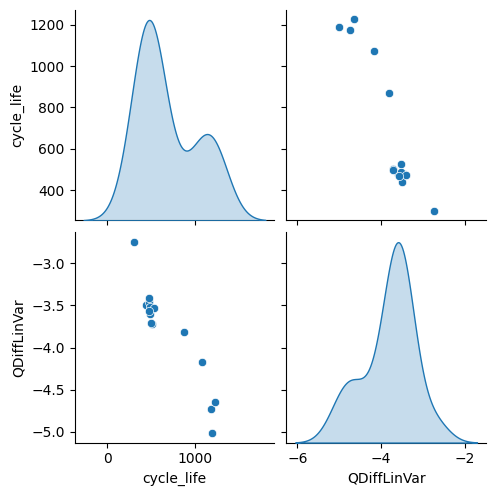

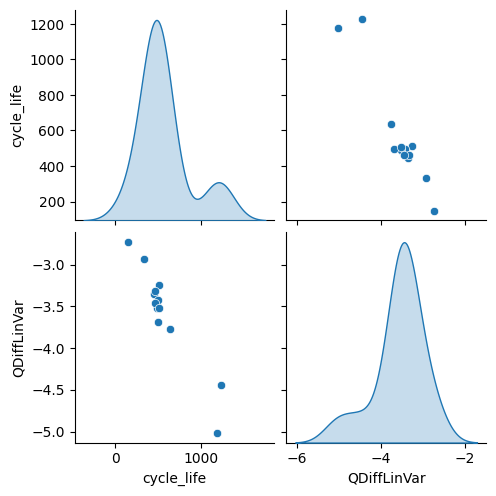

In [25]:
normal_charge_train_ds = normal_charge_dataset.iloc[0::2, :]
normal_charge_test_ds = normal_charge_dataset.iloc[1::2, :]
sns.pairplot(normal_charge_train_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
sns.pairplot(normal_charge_test_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')

In [26]:
normalcharge_train_features = normal_charge_train_ds.copy()
normalcharge_test_features = normal_charge_test_ds.copy()

normal_train_labels = normalcharge_train_features.pop('cycle_life')
normal_test_labels = normalcharge_test_features.pop('cycle_life')


### Compile and fit

In [27]:
variance_model_normal_charge_traditional = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(1, activation='relu'),
    layers.Dense(1, activation='linear')
])
variance_model_normal_charge_traditional.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
    )
variance_model_normal_charge_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
    )

In [28]:
%%time
history_tl = variance_model_normal_charge_tl.fit(
    normalcharge_train_features['QDiffLinVar'],
    normal_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/1000
1/1 [==============================] - 0s 365ms/step - loss: 626838.6875 - mae: 721.1367 - val_loss: 227413.8906 - val_mae: 476.7207
Epoch 2/1000
1/1 [==============================] - 0s 22ms/step - loss: 626770.9375 - mae: 721.1024 - val_loss: 227399.7500 - val_mae: 476.7060
Epoch 3/1000
1/1 [==============================] - 0s 22ms/step - loss: 626703.3750 - mae: 721.0682 - val_loss: 227385.6406 - val_mae: 476.6913
Epoch 4/1000
1/1 [==============================] - 0s 23ms/step - loss: 626635.7500 - mae: 721.0340 - val_loss: 227371.5469 - val_mae: 476.6766
Epoch 5/1000
1/1 [==============================] - 0s 23ms/step - loss: 626568.0625 - mae: 720.9998 - val_loss: 227357.4219 - val_mae: 476.6619
Epoch 6/1000
1/1 [==============================] - 0s 23ms/step - loss: 626500.4375 - mae: 720.9655 - val_loss: 227343.2969 - val_mae: 476.6472
Epoch 7/1000
1/1 [==============================] - 0s 23ms/step - loss: 626432.8125 - mae: 720.9313 - val_loss: 227329.1875 - va

KeyboardInterrupt: 

In [ ]:
%%time
history_traditional = variance_model_normal_charge_traditional.fit(
    normalcharge_train_features['QDiffLinVar'],
    normal_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

### Plot loss graph

In [ ]:
def plot_loss(hist_trad, hist_tl):
  plt.plot(np.sqrt(hist_trad.history['loss']), label='loss_traditional')
  plt.plot(np.sqrt(hist_trad.history['val_loss']), label='val_loss_traditional')
  plt.plot(np.sqrt(hist_tl.history['loss']), label='loss_tl')
  plt.plot(np.sqrt(hist_tl.history['val_loss']), label='val_loss_tl')
  # plt.ylim([200, 130])
  plt.ylim([100, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)

plot_loss(history_traditional, history_tl)

In [ ]:
hist = pd.DataFrame(history_tl.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist



In [ ]:
hist2 = pd.DataFrame(history_traditional.history)
hist2 = hist.pow(0.5)
hist2['epoch'] = history_traditional.epoch
hist2

In [ ]:
test_results['normal_charge_variance_model_tl'] = variance_model_normal_charge_tl.evaluate(
    normalcharge_test_features['QDiffLinVar'],
    normal_test_labels, verbose=1) #sqrt for mse
test_results['normal_charge_variance_model_traditional'] = variance_model_normal_charge_traditional.evaluate(
    normalcharge_test_features['QDiffLinVar'],
    normal_test_labels, verbose=1) #sqrt for mse

In [ ]:
def plot_prediction(y_train, y_test):
  plt.axes(aspect='equal')
  plt.scatter(y_train, normal_train_labels, label='Predictions (train)')
  plt.scatter(y_test, normal_test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

normal_train_prediction = variance_model_normal_charge_tl.predict(normal_charge_train_ds['QDiffLinVar'])
normal_test_prediction = variance_model_normal_charge_tl.predict(normal_charge_test_ds['QDiffLinVar'])
plot_prediction(normal_train_prediction, normal_test_prediction)



In [ ]:
normal_train_prediction2 = variance_model_normal_charge_traditional.predict(normal_charge_train_ds['QDiffLinVar'])
normal_test_prediction2 = variance_model_normal_charge_traditional.predict(normal_charge_test_ds['QDiffLinVar'])
plot_prediction(normal_train_prediction2, normal_test_prediction2)

In [ ]:
test_results['normal_charge_variance_model_tl'][0] = test_results['normal_charge_variance_model_tl'][0] ** 0.5
test_results['normal_charge_variance_model_traditional'][0] = test_results['normal_charge_variance_model_traditional'][0] ** 0.5
pd.DataFrame(test_results, index=['MSE', 'MAE']).T

# Scratch Test

In [ ]:
# model = tf.keras.Sequential(
#     [
#         layers.Dense(2, activation="relu"),
#         layers.Dense(3, activation="relu"),
#         layers.Dense(4),
#     ]
# ) 
# model.summary()